In [1]:
"""
Chained evaluation of the models.
"""
import argparse
import datetime
import h5py
import json
import os
import time
from pathlib import Path

import numpy as np
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
from transformers import AutoTokenizer, CLIPTextModel, BertTokenizer, BertModel

import util.misc as misc
from engine_node2node import get_text_embeddings
from util.datasets import build_shape_surface_occupancy_dataset


def get_args_parser():
    parser = argparse.ArgumentParser("Performing Chained Eval", add_help=False)

    # Model parameters
    parser.add_argument(
        "--batch_size",
        default=32,
        type=int,
        help="Batch size per GPU (effective batch size is batch_size * accum_iter * # gpus",
    )
    parser.add_argument(
        "--text_model_name",
        type=str,
        help="Text model name to use",
    )
    parser.add_argument(
        "--ae",
        type=str,
        metavar="MODEL",
        help="Name of autoencoder",
    )
    parser.add_argument(
        "--ae-latent-dim",
        type=int,
        default=512*8,
        help="AE latent dimension",
    )
    parser.add_argument(
        "--ae_pth",
        required=True,
        help="Autoencoder checkpoint"
    )
    parser.add_argument(
        "--point_cloud_size",
        default=2048,
        type=int,
        help="input size"
    )
    parser.add_argument(
        "--fetch_keys",
        action="store_true",
        default=False,
    )
    parser.add_argument(
        "--use_clip",
        action="store_true",
        default=False,
    )
    parser.add_argument(
        "--use_embeds",
        action="store_true",
        default=False,
    )
    parser.add_argument(
        "--intensity_loss",
        action="store_true",
        default=False,
        help="Contrastive edit intensity loss using ground-truth labels.",
    )

    # Dataset parameters
    parser.add_argument(
        "--dataset",
        type=str,
        help="dataset name",
    )
    parser.add_argument(
        "--data_path",
        type=str,
        help="dataset path",
    )
    parser.add_argument(
        "--data_type",
        type=str,
        help="dataset type",
    )
    parser.add_argument(
        "--max_edge_level",
        default=None,
        type=int,
        help="maximum edge level to use",
    )
    parser.add_argument(
        "--chain_length",
        default=None,
        type=int,
        help="length of chains to load",
    )
    parser.add_argument(
        "--device", default="cuda", help="device to use for training / testing"
    )
    parser.add_argument("--seed", default=0, type=int)
    parser.add_argument("--num_workers", default=60, type=int)
    parser.add_argument(
        "--pin_mem",
        action="store_true",
        help="Pin CPU memory in DataLoader for more efficient (sometimes) transfer to GPU.",
    )
    parser.add_argument(
        "--alt_ae_embeds",
        type=str,
        default=None,
        help="Alternative autoencoder embeddings to use",
    )
    parser.add_argument(
        "--ft_bert",
        action="store_true",
        default=False,
        help="Also fine-tune the BERT model",
    )
    parser.add_argument(
        "--model",
        type=str,
        metavar="MODEL",
    )
    parser.add_argument(
        "--resume",
        default="",
        help="Resume from checkpoint"
    )
    parser.add_argument(
        "--resume_full_weights",
        action="store_true",
        default=False,
        help="Resume the full model weights with the EDM wrapper",
    )

    return parser

In [22]:
import models.mlp_mapper as mlp_mapper

"""
mlp_mapper_bert_bneck_512_pcae
/ibex/user/slimhy/Shape2VecSet/output/graph_edit/dm/mlp_mapper_bert_bneck_512_pcae__fine_chained/checkpoint-59.pth

mlp_mapper_bert_bneck_1024_pcae
/ibex/user/slimhy/Shape2VecSet/output/graph_edit/dm/mlp_mapper_bert_bneck_1024_pcae__fine_chained/checkpoint-59.pth

mlp_mapper_bert_l4_pcae
/ibex/user/slimhy/Shape2VecSet/output/graph_edit/dm/mlp_mapper_bert_l4_pcae__fine_chained/checkpoint-59.pth

"""

# Set dummy arg string to debug the parser
call_string = """--ae_pth /ibex/user/slimhy/Shape2VecSet/output/pc_ae/best_model.pt \
    --ae-latent-dim 256 \
    --text_model_name bert-base-uncased \
    --dataset graphedits_nrl \
    --data_path /ibex/user/slimhy/ShapeWalk/ \
    --data_type release_chained \
    --num_workers 8 \
    --model mlp_mapper_bert_bneck_1024_pcae \
    --resume /ibex/user/slimhy/Shape2VecSet/output/graph_edit/dm/mlp_mapper_bert_bneck_1024_pcae__fine_chained/checkpoint-59.pth \
    --resume_full_weights \
    --device cuda \
    --fetch_keys \
    --use_embeds \
    --alt_ae_embeds pc_ae \
    --seed 0"""

# Parse the arguments
args = get_args_parser()
args = args.parse_args(call_string.split())
args.use_clip = "clip" in args.text_model_name
device = torch.device(args.device)

model = mlp_mapper.__dict__[args.model](use_linear_proj=not args.use_clip)
model.to(device)

# Load the checkpoint
if args.resume:
    print("Loading checkpoint [%s]..." % args.resume)
    checkpoint = torch.load(args.resume, map_location="cpu")
    model.load_state_dict(checkpoint["model"])
    print("Done.")

Loading checkpoint [/ibex/user/slimhy/Shape2VecSet/output/graph_edit/dm/mlp_mapper_bert_bneck_1024_pcae__fine_chained/checkpoint-59.pth]...
Done.


In [23]:
from torch.utils.data import Dataset, DataLoader, Sampler


def get_loader(args, batch_size):
    args.batch_size = batch_size
    args.intensity_loss = True

    dataset_val = build_shape_surface_occupancy_dataset("val", args=args)
    data_loader_val = torch.utils.data.DataLoader(
        dataset_val,
        batch_size=args.batch_size,
        shuffle=False,
        num_workers=args.num_workers,
        pin_memory=True,
        drop_last=True
    )

    return data_loader_val

In [24]:
# --------------------
# Fix the seed for reproducibility
seed = args.seed + misc.get_rank()
torch.manual_seed(seed)
np.random.seed(seed)

cudnn.benchmark = True

args.fetch_keys = True
# --------------------

In [25]:
import json
import torch
import numpy as np
import os.path as osp
import pprint
import warnings

from argparse import ArgumentParser
from models.mlp import MLP
from models.point_net import PointNet
from models.pointcloud_autoencoder import PointcloudAutoencoder


def describe_pc_ae(args):
    # Make an AE.
    if args.encoder_net == "pointnet":
        ae_encoder = PointNet(init_feat_dim=3, conv_dims=args.encoder_conv_layers)
        encoder_latent_dim = args.encoder_conv_layers[-1]
    else:
        raise NotImplementedError()

    if args.decoder_net == "mlp":
        ae_decoder = MLP(
            in_feat_dims=encoder_latent_dim,
            out_channels=args.decoder_fc_neurons + [args.n_pc_points * 3],
            b_norm=False,
        )

    model = PointcloudAutoencoder(ae_encoder, ae_decoder)
    return model


def load_state_dicts(checkpoint_file, map_location=None, **kwargs):
    """ Load torch items from saved state_dictionaries"""
    if map_location is None:
        checkpoint = torch.load(checkpoint_file)
    else:
        checkpoint = torch.load(checkpoint_file, map_location=map_location)

    for key, value in kwargs.items():
        value.load_state_dict(checkpoint[key])

    epoch = checkpoint.get('epoch')
    if epoch:
        return epoch


def read_saved_args(config_file, override_or_add_args=None, verbose=False):
    """
    :param config_file: json file containing arguments
    :param override_args: dict e.g., {'gpu': '0'} will set the resulting arg.gpu to be 0
    :param verbose:
    :return:
    """
    parser = ArgumentParser()
    args = parser.parse_args([])
    with open(config_file, "r") as f_in:
        args.__dict__ = json.load(f_in)

    if override_or_add_args is not None:
        for key, val in override_or_add_args.items():
            args.__setattr__(key, val)

    if verbose:
        args_string = pprint.pformat(vars(args))
        print(args_string)

    return args


def load_pretrained_pc_ae(model_file):
    config_file = osp.join(osp.dirname(model_file), "config.json.txt")
    pc_ae_args = read_saved_args(config_file)
    pc_ae = describe_pc_ae(pc_ae_args)

    if osp.join(pc_ae_args.log_dir, "best_model.pt") != osp.abspath(model_file):
        warnings.warn(
            "The saved best_model.pt in the corresponding log_dir is not equal to the one requested."
        )

    best_epoch = load_state_dicts(model_file, model=pc_ae)
    print(f"Pretrained PC-AE is loaded at epoch {best_epoch}.")
    return pc_ae, pc_ae_args


# Instantiate autoencoder
print("Loading autoencoder [%s]..." % args.ae_pth)
pc_ae, pc_ae_args = load_pretrained_pc_ae(args.ae_pth)
pc_ae = pc_ae.to(device)
pc_ae = pc_ae.eval()
print("Done.")

Loading autoencoder [/ibex/user/slimhy/Shape2VecSet/output/pc_ae/best_model.pt]...
Pretrained PC-AE is loaded at epoch 186.
Done.


/tmp/ipykernel_1893237/3058541129.py:77: UserWarning: The saved best_model.pt in the corresponding log_dir is not equal to the one requested.
  warnings.warn(


In [26]:
from plot_pc import plot_pointclouds

def apply_edit(net, x_a, embed_ab):
    # Reshape from (B, D, K) to (B, M)
    x_a = x_a.flatten(1)
    embed_ab = embed_ab.flatten(1)

    # Concatenate the latent vector with the embedding
    edit_vec, magnitude = net.forward_decoupled(x_a, embed_ab)

    # Add the edit vector to the latent vector
    return (edit_vec * magnitude) + x_a, edit_vec, magnitude


In [27]:
from util.misc import AverageMeter, MetricLogger
from losses.chamfer import chamfer_loss
from collections import defaultdict

model = model.eval()
metric_meter = MetricLogger()

def get_affected_param(edge_dict):
    edge_dict = json.loads(edge_dict)
    edge = list(edge_dict.keys())
    if len(edge) > 2:
        return "err"
    else:
        return edge[0]

sel_params = {"v_x", "v_y", "v_z", "v_seat_pos"}
#sel_params = {"v_curvature", "v_tr_scale_y", "v_tr_scale_z", "v_seat_shape"}
all_mag_preds = defaultdict(list)

def get_metrics(data_loader):
    with torch.no_grad():
        for batch_k, (edit_keys, x_a, x_b, embed_ab, edit_intensity, edge_dict, labels) in enumerate(data_loader):  
            x_a = x_a.cuda()
            x_b = x_b.cuda()
            embed_ab = embed_ab.cuda()

            # Apply the edits
            x_b_edited, edit_vec, magnitude = apply_edit(net=model, x_a=x_a, embed_ab=embed_ab)
    
            # Compute average pairwise L2 distance in feature space
            l2_dist = torch.norm(x_b_edited - x_b, p=2)
            avg_mag = magnitude.mean().item()

            # Map each intensity to the corresponding magnitude
            intensity_to_idx_list = {intensity.item(): [] for intensity in torch.unique(edit_intensity)}
            for idx, intensity in enumerate(edit_intensity):
                affected_p = get_affected_param(edge_dict[idx])
                if affected_p not in sel_params: continue
                intensity_to_idx_list[intensity.item()].append(idx)
                all_mag_preds[intensity.item()].append(magnitude[idx].item())

            # Compute the average edit magnitude for each intensity
            for intensity, idx_list in intensity_to_idx_list.items():
                if len(idx_list) > 0:
                    avg_mag = magnitude[idx_list].mean().item()
                    metric_meter.update(**{f"avg_mag_{intensity}": avg_mag})

            metric_meter.update(avg_l2_dist=l2_dist.item())

            prev_node = x_b_edited

    return metric_meter

data_loader_val = get_loader(args, batch_size=32)
metric_meter = get_metrics(data_loader_val)

print(str(metric_meter))

/home/slimhy/conda/envs/shape2vecset/lib/python3.10/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


avg_mag_1: 0.3804 (0.4133)	avg_mag_2: 0.7024 (0.7171)	avg_mag_3: 0.8919 (0.7681)	avg_mag_5: 1.2348 (1.3194)	avg_mag_6: 1.6177 (1.6080)	avg_l2_dist: 4.3049 (4.5194)	avg_mag_4: 1.1346 (1.1728)	avg_mag_7: 1.7876 (1.9397)	avg_mag_8: 2.4300 (2.2154)	avg_mag_9: 2.4870 (2.4991)


In [28]:
# Concatenate all predicted magnitudes
all_mag_preds_v = {k: np.array(v) for k, v in all_mag_preds.items()}
all_mag_preds_v = np.concatenate(list(all_mag_preds_v.values()))

# Get min-max of all mag_pred values
min_mag = np.min(all_mag_preds_v)
max_mag = np.max(all_mag_preds_v)

# Min-max normalize the magnitudes
all_mag_preds__mmax = {k: (np.array(v) - min_mag) / (max_mag - min_mag) for k, v in all_mag_preds.items()}

In [29]:
# Discretize the magnitudes into 10 bins
all_mag_preds__dig = {k: np.digitize(v, np.linspace(0, 1, 9)) for k, v in all_mag_preds__mmax.items()}

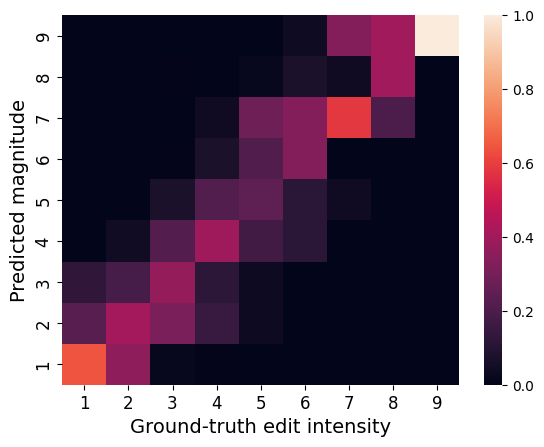

In [30]:
# Plot a confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

gt = list(range(9, 0, -1))

# Compute the confusion matrix
conf_mat = np.zeros((len(gt), len(gt)))

for i, gt_i in enumerate(gt):
    for j, gt_j in enumerate(gt):
        if gt_i in all_mag_preds__dig:
            conf_mat[i, j] = np.sum(all_mag_preds__dig[gt_i] == gt_j)
        else:
            conf_mat[i, j] = 1e-8

# Normalize the confusion matrix
conf_mat = conf_mat / np.sum(conf_mat, axis=0, keepdims=True)

# Plot the confusion matrix
sns.heatmap(conf_mat, annot=False, xticklabels=gt, yticklabels=gt)

# Flip x axis 
plt.gca().invert_xaxis()

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("Ground-truth edit intensity", fontsize=14)
plt.ylabel("Predicted magnitude", fontsize=14)

# Save the figure to SVG
plt.savefig("conf_mat__xyz_LATE_FUSION_1024.svg", bbox_inches="tight", pad_inches=0.1)

In [21]:
np.sum(conf_mat, axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1.])